## Preprocessing for Feature 

- Before proceed, check if number of polygons matches the number of generated files (polygon-boxes, squares)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure as skie
import skimage
import numpy as np
import glob
import cv2
import tqdm
from cv2 import normalize
from skimage.restoration import denoise_tv_chambolle

from pathlib import Path
from PIL import Image,ImageOps


In [17]:
img_path = '/home/richard/data/Schiefer/tests/CFB184_clipped_raster_files_pred/CFB184_ortho_rgb_mask_0108_10.png' # tanne
#img_path = '/home/richard/data/Schiefer/tests/CFB184_clipped_raster_files_pred/CFB184_ortho_rgb_mask_0013_12.png' # kiefer
#img_path = '/home/richard/data/Schiefer/tests/CFB184_clipped_raster_files_pred/CFB184_ortho_rgb_mask_0109_8.png' # deadwood
img = cv2.imread(img_path)
#img = skimage.color.rgb2gray(img) # preserves luminance of img
print(type(img))

<class 'numpy.ndarray'>


#### Denoising


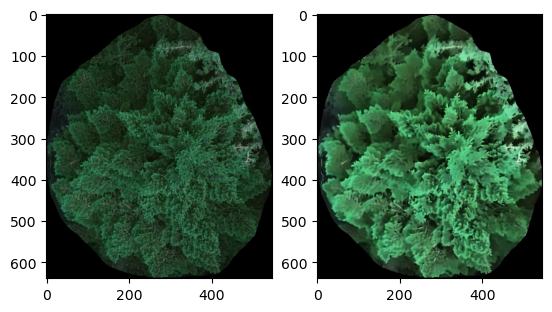

In [18]:

dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
dst = skie.equalize_adapthist(dst)

plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(dst)
plt.show()

#### Total Variation Filter

- tackles signals with excessive spurious detail have high variation
- reducing the total variation of the signal, removes unwanted detail while preserving important details such as edges

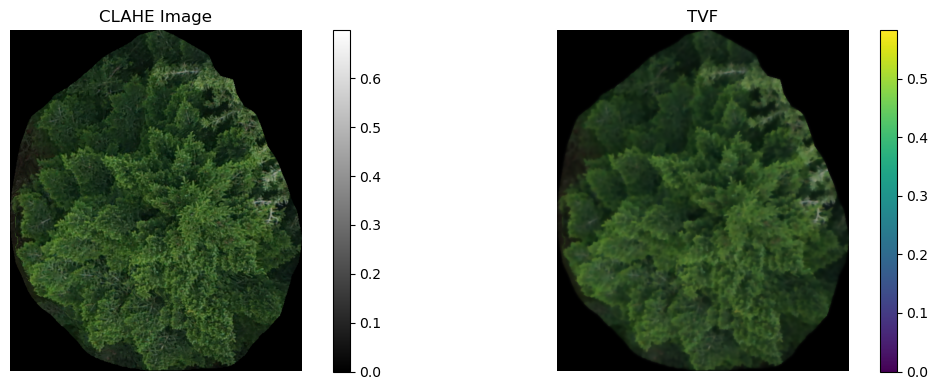

In [10]:


fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4),
                               sharex=True, sharey=True)

img0 = ax0.imshow(img, cmap=plt.cm.gray)
ax0.set_title("CLAHE Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(denoise_tv_chambolle(img, weight=0.1, channel_axis=-1))
ax1.set_title("TVF")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

fig.tight_layout()

plt.show()

#### Histogramm normalization

- with CLAHE
  - Two benefits: normalize brightness, reduce differences between darker and light images
  - enhance contrast of image (stronger responses in conv layers)

Kinda only useful for square images otherwise black pixels are appearing too often, but still brightness is normalized.

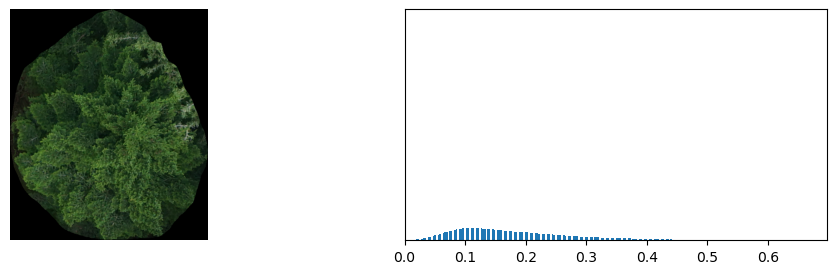

In [7]:
def show(img): #displays image next to a histogram
    # Display the image.
    fig, (ax1, ax2) = plt.subplots(1, 2,
                                   figsize=(12, 3))

    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_axis_off()

    # Display the histogram.
    ax2.hist(img.ravel(), lw=0, bins=256)
    ax2.set_xlim(0, img.max())
    ax2.set_yticks([])

    plt.show()

show(img)

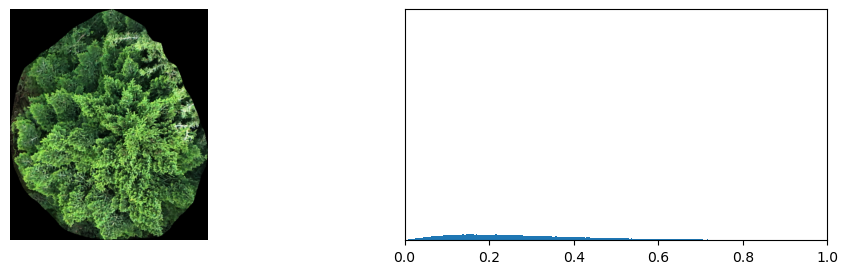

In [12]:
# Contrast Limited Adaptive Histogram Equalization (CLAHE) applied
show(skie.equalize_adapthist(img))
# under the hood works rescale_intensity, equalize_adapthist,

clahe_image = skie.equalize_adapthist(img)

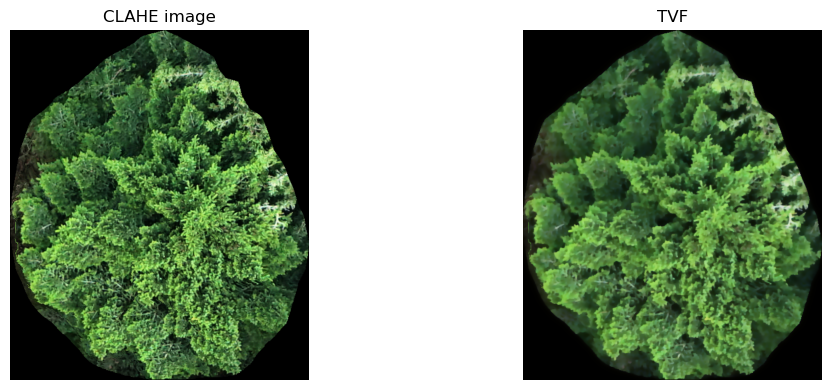

In [15]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4),
                               sharex=True, sharey=True)

img0 = ax0.imshow(clahe_image, cmap=plt.cm.gray)
ax0.set_title("CLAHE image")
ax0.axis("off")

img1 = ax1.imshow(denoise_tv_chambolle(clahe_image, weight=0.1, channel_axis=-1))
ax1.set_title("TVF")
ax1.axis("off")

fig.tight_layout()

plt.show()

In [ ]:
new = skie.equalize_adapthist(img)
print(type(new))
PIL_image = Image.fromarray((new * 255).astype(np.uint8))
plt.imshow(PIL_image)
print(PIL_image.size)

#### Contrast Stretching

#### Resize images

VGG16 and ResNet default size = 224. Use this size for square crowns. So they can be directly fed into the CNN.

#### _____________________

In [2]:

def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

def pil_resize(img, expected_size):
    image = img
    new_image = image.resize((expected_size,expected_size))
    return new_image

def get_png_file_names(file_dir):
    files = glob.glob(file_dir + '/*.png')
    print("num files",len(files))
    return files

def normalize_img(img_arr):
    normalized_img = cv2.normalize(img_arr, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    normalized_img = normalized_img.astype(np.uint8)
    return normalized_img

def highest_pixel_count(img_array):
    pixel, n_of_pixels = np.unique(img_array, return_counts=True)
    highest_pixel_value = pixel[np.argsort(-n_of_pixels)]
    index = 0
    forbidden_values = {0,1,2}
    while True:
        if highest_pixel_value[index] not in forbidden_values:
            return highest_pixel_value[index]
        index += 1
        
    """_summary_
    do it on orthoreference images from schiefer and count the pixels that lie inside the ground truth of schiefer
    """

def check_alpha_channel(img_arr):
    h,w,c = img_arr.shape
    return True if c ==4 else False

def preprocess_images(images_path, expected_size, square):
    file_list = get_png_file_names(images_path)
    shape = 'polygon'
    if square:
        shape = 'square'
    out_dir = Path(images_path).parent / Path('preprocessed_' + str(expected_size) + '_' + shape + '_clipped_pred_' + str(len(file_list)))
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    for img in (pbar := tqdm.tqdm(file_list)):
        pbar.set_description(f"Processing {img}")
        file_name = Path(img).stem
        img = cv2.imread(img)
        # remove alpha if image has alpha (TODO: handle automatically)
        processed_img = img[:,:,:3]
        # denoise image
        processed_img = cv2.fastNlMeansDenoisingColored(processed_img,None,10,10,7,21) # increases processing time
        # normalize brightness CLAHE
        processed_img = skie.equalize_adapthist(img)
        #processed_img = denoise_tv_chambolle(img, weight=0.1, channel_axis=-1)
        # normalize pixel values to range 0-255
        processed_img = normalize_img(processed_img)
        # calc pixel count
        #pixel_count = highest_pixel_count(processed_img)
        # array to img
        #PIL_image = Image.fromarray((processed_img * 255).astype(np.uint8)) # default method not normalized pixel
        PIL_image = Image.fromarray((processed_img).astype(np.uint8)) # if normalized
        # resize
        #PIL_image = resize_with_padding(PIL_image,(expected_size,expected_size))
        PIL_image = PIL_image.resize((expected_size, expected_size)) # use for squares (strecthed) TODO: implement flag to chose from both
        PIL_image.save(str(out_dir) + '/' + str(file_name) + '_preprocessed' + '.png')

In [3]:
# multiple
polygon_crops_path = '/home/richard/data/Schiefer/combine/pred_square_clipped_raster_files'
assert Path(polygon_crops_path).is_dir()

print(Path(polygon_crops_path).parent / 'preprocessed')

preprocess_images(polygon_crops_path, 224, square=True)

/home/richard/data/Schiefer/combine/preprocessed
num files 1140


Processing /home/richard/data/Schiefer/combine/pred_square_clipped_raster_files/CFB167_ortho_mask_0146_12.png: 100%|██████████| 1140/1140 [08:50<00:00,  2.15it/s]


In [26]:
square_crops_path = '/home/richard/data/Schiefer/feature_extraction/clips/CFB184_clipped_raster_files_pred_square/'
polygon_crops_path = '/home/richard/data/Schiefer/feature_extraction/clips/CFB184_clipped_raster_files_pred_polygon/'

square_gt_crops_path = '/home/richard/data/Schiefer/feature_extraction/clips/CFB184_clipped_raster_files_gt_square/'
polygon__gt_crops_path = '/home/richard/data/Schiefer/feature_extraction/clips/CFB184_clipped_raster_files_gt_polygon/'

assert Path(polygon_crops_path).is_dir()
assert Path(square_crops_path).is_dir()

print(Path(square_crops_path).parent / 'preprocessed')

preprocess_images(polygon__gt_crops_path,224, square=False)

/home/richard/data/Schiefer/feature_extraction/clips/preprocessed
num files 296


Processing /home/richard/data/Schiefer/feature_extraction/clips/CFB184_clipped_raster_files_gt_polygon/CFB184_ortho_rgb_mask_0291_12.png: 100%|██████████| 296/296 [03:53<00:00,  1.27it/s]


#### Test section

In [ ]:
imgs_dir = '/home/richard/data/Schiefer/preprocessedwithpixel_224/'
files = glob.glob(imgs_dir + '*.png')
num = []
for f in files:
    f = Path(f).stem
    f = f.split('_')[5]
    num.append(f)

unique, counts = np.unique(num,return_counts=True)
counts = sorted(counts,reverse=True)
print("unique values",len(unique))
for value, number in zip(unique, counts):
    print(value,number)

In [ ]:
imgs_dir = '/home/richard/data/Schiefer/tests/CFB184_clipped_raster_files_squares/'
files = glob.glob(imgs_dir + '*.png')
print(len(files))
num = []
for f in files:
    f = Path(f).stem
    f = f.split('_')[4]
    num.append(f)

unique, counts = np.unique(num,return_counts=True)
counts = sorted(counts,reverse=True)
print("unique values",len(unique))
for value, number in zip(unique, counts):
    print(value,number)

In [ ]:
# test one image
img_path = '/home/richard/data/Schiefer/preprocessed_224/CFB184_ortho_rgb_0002_preprocessed.png'
assert Path(img_path).exists()

img_arr = plt.imread(img_path)
print(type(img_arr))
pixel, n_of_pixels = np.unique(img_arr, return_counts=True)
highest_pixel_value = pixel[np.argsort(-n_of_pixels)]
print(type(highest_pixel_value[2]))


new_img = normalize(img_arr, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
new_img = new_img.astype(np.uint8)
print(type(new_img))
plt.imshow(new_img)
print(type(new_img))

In [ ]:
def normalize_img(img_arr):
    normalized_img = cv2.normalize(img_arr, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    normalized_img = normalized_img.astype(np.uint8)
    return normalized_img

def highest_pixel_count(img_array):
    pixel, n_of_pixels = np.unique(img_array, return_counts=True)
    highest_pixel_value = pixel[np.argsort(-n_of_pixels)]
    index = 0
    forbidden_values = {0,1}
    while True:
        if highest_pixel_value[index] not in forbidden_values:
            return highest_pixel_value[index]
        index += 1


new = normalize_img(img_arr)
count = highest_pixel_count(new)


# vis
PIL_image = Image.fromarray(new)
plt.imshow(PIL_image)

In [ ]:
# improve selecting, skip if highest pixel count == 0 or 1 